###  Import Libraries and Load Data

In [253]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [254]:
file_path = r'C:\Users\USER\Desktop\my_tasks\Week_15\Kaggle proj\train.csv'

###  EDA-Based Data Quality Assessment

In [255]:
def load_check_data_quality(file_path):
    """
    Loads dataset, performs basic data quality check
    
    Steps:
    1. Load CSV file.
    2. check missing value.
    3. check for duplicate.
    4. Check skewness for variables identified in EDA as right-skewed.
  
    """
    
    # === 1. Load dataset ===
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully: {file_path}")
        df_processed = df.copy()
        print(f"Shape: {df_processed.shape[0]} rows × {df_processed.shape[1]} columns\n")
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

    # === 1. Missing Values ===
    print("\n=== MISSING VALUE PERCENTAGES ===")
    missing = df_processed.isnull().mean() * 100
    print(missing[missing > 0].sort_values(ascending=False))

    # 2. Check for duplicates
    print("\n2. Duplicate Rows:")
    duplicates = df_processed.duplicated().sum()
    print(f"Number of duplicate rows: {duplicates}")
    if duplicates > 0:
        print(f"Percentage of duplicates: {(duplicates/len(df_processed))*100:.2f}%")

    # 3. Drop id column since it's not needed for analysis
    if 'id' in df_processed.columns:
        df_processed.drop('id', axis=1, inplace=True)


    # 4. Check skewness for variables identified in EDA as right-skewed
    print("\n3. Skewness Analysis (EDA identified right-skewed variables):")
    skewed_vars = ['annual_income', 'debt_to_income_ratio']
    for var in skewed_vars:
         if var in df_processed.columns:
            skewness = skew(df_processed[var])
         print(f"{var}: skewness = {skewness:.3f} "
         f"({'strongly skewed' if abs(skewness) > 0.7 else 'moderately skewed' if abs(skewness) > 0.3 else 'approximately normal'})")
    
    # 5. Check correlation with target (EDA evidence)
    print("\n4. Correlation with loan_paid_back (EDA Evidence):")
    num_features = df_processed.select_dtypes(include=['int64', 'float64']).columns
    num_features = pd.DataFrame(df_processed[num_features])
    correlations = num_features.corr()['loan_paid_back'].sort_values(key=abs, ascending=False)
    print("High-signal features (|correlation| > 0.2):")
    high_signal = correlations[abs(correlations) > 0.2].drop('loan_paid_back')
    for feature, corr in high_signal.items():
        print(f"  {feature}: {corr:.3f}")

    print("\nLow-signal features (|correlation| < 0.1):")
    low_signal = correlations[abs(correlations) < 0.1]
    for feature, corr in low_signal.items():
        print(f"  {feature}: {corr:.3f}")
   
    return df_processed


In [256]:
df_processed = load_check_data_quality(file_path)

Dataset loaded successfully: C:\Users\USER\Desktop\my_tasks\Week_15\Kaggle proj\train.csv
Shape: 593994 rows × 13 columns


=== MISSING VALUE PERCENTAGES ===
Series([], dtype: float64)

2. Duplicate Rows:
Number of duplicate rows: 0

3. Skewness Analysis (EDA identified right-skewed variables):
annual_income: skewness = 1.720 (strongly skewed)
debt_to_income_ratio: skewness = 1.407 (strongly skewed)

4. Correlation with loan_paid_back (EDA Evidence):
High-signal features (|correlation| > 0.2):
  debt_to_income_ratio: -0.336
  credit_score: 0.235

Low-signal features (|correlation| < 0.1):
  annual_income: 0.006
  loan_amount: -0.004


####  Handle Duplicates

In [257]:
# Remove duplicates if any (EDA didn't report duplicates, but let's be thorough)
duplicates = df_processed.duplicated().sum()
if duplicates > 0:
    print(f"Removing {duplicates} duplicate rows...")
    df_processed = df_processed.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {df_processed.shape}")
else:
    print("✓ No duplicates to remove (as expected from EDA)")

✓ No duplicates to remove (as expected from EDA)


#### Log-Transform Skewed Variables (EDA Recommendation)

In [258]:
import numpy as np
from scipy.stats import skew

def transform_loan_payback_data(df):
    """
    Step: Normalization
    ---------------------
    Safely applies log transformation to skewed numeric features.
    Handles zeros, negatives, and NaNs automatically.
    """
    print("=== LOG-TRANSFORMING SKEWED VARIABLES ===")
    print("EDA identified these variables as right-skewed and recommended log transformation:")

    # Variables identified as skewed from EDA
    skewed_vars = ['annual_income', 'debt_to_income_ratio']

    for var in skewed_vars:
        if var in df.columns:
            # Ensure numeric
            if not np.issubdtype(df[var].dtype, np.number):
                print(f"Skipping {var}: non-numeric column.")
                continue

            # Handle NaN safely
            df_processed[var] = df_processed[var].fillna(0)

            # Check for zeros/negatives
            min_val = df_processed[var].min()
            if min_val <= 0:
                shift = abs(min_val) + 1
                df_processed[f'{var}_log'] = np.log1p(df_processed[var] + shift)
                print(f"✓ {var}: Shifted by {shift:.2f} and applied log1p (min={min_val:.3f})")
            else:
                df_processed[f'{var}_log'] = np.log1p(df[var])
                print(f"✓ {var}: Applied log1p transformation (all positive values)")

            # Compute skewness safely
            try:
                original_skew = skew(df_processed[var], nan_policy='omit')
                transformed_skew = skew(df_processed[f'{var}_log'], nan_policy='omit')
                print(f"  Original skewness: {original_skew:.3f} → Transformed skewness: {transformed_skew:.3f}")
            except Exception as e:
                print(f"Skewness computation failed for {var}: {e}")

    print(f"\nDataset shape after log transformation: {df_processed.shape}")
    print("New log-transformed columns:", [col for col in df_processed.columns if '_log' in col])
    print("Normalization (log transform) complete.\n")

    return df


In [259]:
df_processed = transform_loan_payback_data(df_processed)

=== LOG-TRANSFORMING SKEWED VARIABLES ===
EDA identified these variables as right-skewed and recommended log transformation:
✓ annual_income: Applied log1p transformation (all positive values)
  Original skewness: 1.720 → Transformed skewness: -0.342
✓ debt_to_income_ratio: Applied log1p transformation (all positive values)
  Original skewness: 1.407 → Transformed skewness: 1.219

Dataset shape after log transformation: (593994, 14)
New log-transformed columns: ['annual_income_log', 'debt_to_income_ratio_log']
Normalization (log transform) complete.



#### Outlier Treatment (EDA Recommendation)

Based on EDA findings, handle outliers using IQR-capping method

In [260]:
def Outlier_treatment_data(df):
    """
    Data Cleaning
    ---------------------
    Handles duplicates, missing values, inconsistencies, and outliers.
    """

    # Outlier treatment based on EDA recommendations
    print("=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===")
    print("EDA recommended IQR-capping for  to preserve data points")

    # Define numerical columns (excluding target)
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    if 'loan_paid_back' in numerical_cols:
        numerical_cols.remove('loan_paid_back')

    print(f"Treating outliers in {len(numerical_cols)} numerical features...")

    # Apply IQR-capping method
    outliers_capped = 0
    for col in numerical_cols:
        Q1 = df_processed[col].quantile(0.25)
        Q3 = df_processed[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers before capping
        outliers_before = ((df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)).sum()
        
        if outliers_before > 0:
            # Cap outliers
            df_processed[col] = np.where(df_processed[col] < lower_bound, lower_bound, df_processed[col])
            df_processed[col] = np.where(df_processed[col] > upper_bound, upper_bound, df_processed[col])
            outliers_capped += outliers_before
            print(f"✓ {col}: Capped {outliers_before} outliers")

    print(f"\nTotal outliers capped: {outliers_capped}")
    print(f"Dataset shape after outlier treatment: {df_processed.shape}")

    return df


In [261]:
df = Outlier_treatment_data(df_processed)

=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===
EDA recommended IQR-capping for  to preserve data points
Treating outliers in 7 numerical features...
✓ annual_income: Capped 15917 outliers
✓ debt_to_income_ratio: Capped 17556 outliers
✓ credit_score: Capped 5901 outliers
✓ loan_amount: Capped 2902 outliers
✓ interest_rate: Capped 5136 outliers
✓ annual_income_log: Capped 2979 outliers
✓ debt_to_income_ratio_log: Capped 13412 outliers

Total outliers capped: 63803
Dataset shape after outlier treatment: (593994, 14)


###  Encoding(like label encoding and one-hot encoding)

In [262]:
def transform_loan_data(df_processed):
    """
    Step 2: Transformation (Encoding)
    ---------------------------------
    Converts categorical variables into numeric using Label & One-Hot encoding
    for the loan dataset.
    """
    # Label Encoding (binary columns if any)
    # 'loan_paid_back' can be treated as binary target
    label_map = {
        'loan_paid_back': {1: 1, 0: 0}  # optional if already 0/1
    }

    for col, mapping in label_map.items():
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].map(mapping)

    # One-Hot Encoding (multi-category columns)
    onehot_cols = [
        'gender',
        'marital_status',
        'education_level',
        'employment_status',
        'loan_purpose',
        'grade_subgrade'
    ]

    # Convert to numeric using one-hot encoding
    df_processed = pd.get_dummies(df_processed, columns=onehot_cols, drop_first=False, dtype=int)

    print("Transformation (encoding) complete.")
    return df_processed


In [263]:
df_preprocessed = transform_loan_data(df_processed)
print(df_preprocessed.head())

Transformation (encoding) complete.
   annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0       29367.99                 0.084         736.0      2528.42   
1       22108.02                 0.166         636.0      4593.10   
2       49566.20                 0.097         694.0     17005.15   
3       46858.25                 0.065         536.5      4682.48   
4       25496.70                 0.053         665.0     12184.43   

   interest_rate  loan_paid_back  annual_income_log  debt_to_income_ratio_log  \
0          13.67               1          10.287695                  0.080658   
1          12.92               0          10.003741                  0.153579   
2           9.76               1          10.811085                  0.092579   
3          16.10               1          10.754904                  0.062975   
4          10.21               1          10.146344                  0.051643   

   gender_Female  gender_Male  ...  grade_subgrade_E1  grade_s

###  Feature Engineering

In [314]:
def enhance_loan_data(df_preprocessed):
    """
    Step 4: Feature Engineering
    ---------------------------
    Creates new, meaningful derived features for the loan dataset.
    """

    # 1. Debt burden indicator
    df_preprocessed['high_debt_ratio'] = (df_preprocessed['debt_to_income_ratio'] > 0.4).astype(int)

    # 2. Loan-to-income ratio
    df_preprocessed['loan_to_income'] = df_preprocessed['loan_amount'] / (df_preprocessed['annual_income'] + 1)

    # 3. Risk score (simple: low credit score + high interest)
    df_preprocessed['risk_score'] = (
        (700 - df_preprocessed['credit_score']).clip(lower=0) +
        df_preprocessed['interest_rate']
    )

    # 4. Income category
    df_preprocessed['income_bracket'] = pd.cut(
    df_preprocessed['annual_income'],
    bins=[0, 30000, 60000, 100000, df_preprocessed['annual_income'].max()],
    labels=[0, 1, 2, 3]).astype(int)


    # 5. Interaction term: credit score × interest rate
    df_preprocessed['credit_interest_interaction'] = (
        df_preprocessed['credit_score'] * df_preprocessed['interest_rate']
    )

    print("Feature engineering complete.")
    print(f"\nDataset shape after feature engineering: {df_preprocessed.shape}")
    print(f"New engineered features: {[col for col in df_preprocessed.columns if col not in df]}")

    return df_preprocessed


In [315]:
df_preprocessed = enhance_loan_data(df_preprocessed)

Feature engineering complete.

Dataset shape after feature engineering: (593994, 68)
New engineered features: ['gender_Female', 'gender_Male', 'gender_Other', 'marital_status_Divorced', 'marital_status_Married', 'marital_status_Single', 'marital_status_Widowed', "education_level_Bachelor's", 'education_level_High School', "education_level_Master's", 'education_level_Other', 'education_level_PhD', 'employment_status_Employed', 'employment_status_Retired', 'employment_status_Self-employed', 'employment_status_Student', 'employment_status_Unemployed', 'loan_purpose_Business', 'loan_purpose_Car', 'loan_purpose_Debt consolidation', 'loan_purpose_Education', 'loan_purpose_Home', 'loan_purpose_Medical', 'loan_purpose_Other', 'loan_purpose_Vacation', 'grade_subgrade_A1', 'grade_subgrade_A2', 'grade_subgrade_A3', 'grade_subgrade_A4', 'grade_subgrade_A5', 'grade_subgrade_B1', 'grade_subgrade_B2', 'grade_subgrade_B3', 'grade_subgrade_B4', 'grade_subgrade_B5', 'grade_subgrade_C1', 'grade_subgrade_

#### Feature Selection

Based on EDA correlation analysis, select high-signal features and evaluate low-signal ones

In [316]:
def feature_selection_by_correlation(df_preprocessed):
    # Feature selection based on EDA correlation evidence
    print("=== FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE ===")

    # Separate features and target
    X = df_preprocessed.drop('loan_paid_back', axis=1)
    y = df_preprocessed['loan_paid_back']

    print(f"Total features available: {X.shape[1]}")

    # EDA-identified high-signal features (|correlation| > 0.2)
    high_signal_features = ['debt_to_income_ratio', 'credit_score']
    print(f"\nEDA-identified high-signal features: {high_signal_features}")

    # EDA-identified low-signal features (|correlation| < 0.1)
    low_signal_features = ['annual_income', 'loan_amount']
    print(f"EDA-identified low-signal features: {low_signal_features}")

    # Check which features are actually available
    available_high_signal = [f for f in high_signal_features if f in X.columns]
    available_low_signal = [f for f in low_signal_features if f in X.columns]

    print(f"\nAvailable high-signal features: {available_high_signal}")
    print(f"Available low-signal features: {available_low_signal}")

    # Create feature sets for evaluation
    print("\n=== FEATURE SETS FOR EVALUATION ===")

    # Set 1: All original features (excluding low-signal)
    features_exclude_low_signal = [
        col for col in X.columns if col not in low_signal_features
    ]
    print(f"Set 1 - Exclude low-signal features: {len(features_exclude_low_signal)} features")

    # Set 2: High-signal + engineered features
    high_signal_plus_engineered = available_high_signal + [
        col for col in X.columns
        #['gender_Female', 'gender_Male', 'gender_Other', 'marital_status_Divorced', 'marital_status_Married', 'marital_status_Single', 'marital_status_Widowed', "education_level_Bachelor's", 'education_level_High School', "education_level_Master's", 'education_level_Other', 'education_level_PhD', 'employment_status_Employed', 'employment_status_Retired', 'employment_status_Self-employed', 'employment_status_Student', 'employment_status_Unemployed', 'loan_purpose_Business', 'loan_purpose_Car', 'loan_purpose_Debt consolidation', 'loan_purpose_Education', 'loan_purpose_Home', 'loan_purpose_Medical', 'loan_purpose_Other', 'loan_purpose_Vacation', 'grade_subgrade_A1', 'grade_subgrade_A2', 'grade_subgrade_A3', 'grade_subgrade_A4', 'grade_subgrade_A5', 'grade_subgrade_B1', 'grade_subgrade_B2', 'grade_subgrade_B3', 'grade_subgrade_B4', 'grade_subgrade_B5', 'grade_subgrade_C1', 'grade_subgrade_C2', 'grade_subgrade_C3', 'grade_subgrade_C4', 'grade_subgrade_C5', 'grade_subgrade_D1', 'grade_subgrade_D2', 'grade_subgrade_D3', 'grade_subgrade_D4', 'grade_subgrade_D5', 'grade_subgrade_E1', 'grade_subgrade_E2', 'grade_subgrade_E3', 'grade_subgrade_E4', 'grade_subgrade_E5', 'grade_subgrade_F1', 'grade_subgrade_F2', 'grade_subgrade_F3', 'grade_subgrade_F4', 'grade_subgrade_F5', 'high_debt_ratio', 'loan_to_income', 'risk_score', 'income_bracket', 'credit_interest_interaction'
        if any(keyword in col.lower() for keyword in ['ratio', 'interaction','income', 'total', 'log','credit','risk'])
    ]
    print(f"Set 2 - High-signal + engineered (before dedup): {len(high_signal_plus_engineered)} features")

    # Remove duplicates while preserving order
    def unique_ordered(lst):
        seen = set()
        unique = []
        for x in lst:
            if x not in seen:
                unique.append(x)
                seen.add(x)
        return unique

    high_signal_plus_engineered = unique_ordered(high_signal_plus_engineered)

    print(f"Set 2 - High-signal + engineered (after dedup): {len(high_signal_plus_engineered)} features")

    # Set 3: All features (for comparison)
    all_features = list(X.columns)
    print(f"Set 3 - All features: {len(all_features)} features")

    # Final selected features
    selected_features = high_signal_plus_engineered
    print(f"\n✓ FINAL Selected feature set: {len(selected_features)} features")
    print("Selected features:", selected_features)

    return df_preprocessed[selected_features]


In [317]:
df_selected = feature_selection_by_correlation(df_preprocessed)

=== FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE ===
Total features available: 67

EDA-identified high-signal features: ['debt_to_income_ratio', 'credit_score']
EDA-identified low-signal features: ['annual_income', 'loan_amount']

Available high-signal features: ['debt_to_income_ratio', 'credit_score']
Available low-signal features: ['annual_income', 'loan_amount']

=== FEATURE SETS FOR EVALUATION ===
Set 1 - Exclude low-signal features: 65 features
Set 2 - High-signal + engineered (before dedup): 12 features
Set 2 - High-signal + engineered (after dedup): 10 features
Set 3 - All features: 67 features

✓ FINAL Selected feature set: 10 features
Selected features: ['debt_to_income_ratio', 'credit_score', 'annual_income', 'annual_income_log', 'debt_to_income_ratio_log', 'high_debt_ratio', 'loan_to_income', 'risk_score', 'income_bracket', 'credit_interest_interaction']


####  Data Splitting (Stratified)

In [319]:
from sklearn.model_selection import train_test_split

def split_loan_paid_back_data(df_preprocessed, selected_features, target='loan_paid_back'):
    """
    Performs stratified train-validation-test split (80-20 then 75-25)
    while preserving class distribution in loan_paid_back.
    """

    print("=== STRATIFIED DATA SPLITTING ===")
    print("EDA identified class imbalance - using stratified splitting to preserve class distribution")

    # Split features and target
    X = df_preprocessed[selected_features]
    y = df_preprocessed[target]

    print(f"Selected features shape: {X.shape}")
    print(f"Target variable: '{target}'")
    print(f"Unique class distribution:\n{y.value_counts(normalize=True).round(3)}")

    # ---------- First Split (80% train+val, 20% test) ----------
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # ---------- Second Split (75% train, 25% val of 80%) ----------
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
    )

    # ---------- Summary ----------
    print("\n=== DATA SPLIT RESULTS ===")
    print(f"Training set:   {X_train.shape} ({(X_train.shape[0] / len(X)) * 100:.1f}%)")
    print(f"Validation set: {X_val.shape} ({(X_val.shape[0] / len(X)) * 100:.1f}%)")
    print(f"Test set:       {X_test.shape} ({(X_test.shape[0] / len(X)) * 100:.1f}%)")

    # ---------- Class Distribution Verification ----------
    print("\n=== CLASS DISTRIBUTION CHECK ===")
    print("Training set loan_paid_back distribution:")
    print(y_train.value_counts(normalize=True).round(3))
    print("\nValidation set loan_paid_back distribution:")
    print(y_val.value_counts(normalize=True).round(3))
    print("\nTest set loan_paid_back distribution:")
    print(y_test.value_counts(normalize=True).round(3))

    return X_train, X_val, X_test, y_train, y_val, y_test


In [320]:
X_train, X_val, X_test, y_train, y_val, y_test = split_loan_paid_back_data(
    df_preprocessed, 
    selected_features=df_selected.columns
)

=== STRATIFIED DATA SPLITTING ===
EDA identified class imbalance - using stratified splitting to preserve class distribution
Selected features shape: (593994, 10)
Target variable: 'loan_paid_back'
Unique class distribution:
loan_paid_back
1    0.799
0    0.201
Name: proportion, dtype: float64

=== DATA SPLIT RESULTS ===
Training set:   (356396, 10) (60.0%)
Validation set: (118799, 10) (20.0%)
Test set:       (118799, 10) (20.0%)

=== CLASS DISTRIBUTION CHECK ===
Training set loan_paid_back distribution:
loan_paid_back
1    0.799
0    0.201
Name: proportion, dtype: float64

Validation set loan_paid_back distribution:
loan_paid_back
1    0.799
0    0.201
Name: proportion, dtype: float64

Test set loan_paid_back distribution:
loan_paid_back
1    0.799
0    0.201
Name: proportion, dtype: float64


###  Feature Scaling (Normalization / Standardization)

In [321]:
from sklearn.preprocessing import StandardScaler

def scale_loan_features(X_train, X_val, X_test):
    """
    FEATURE SCALING for loan_paid_back dataset
    ----------------------------------------
    Applies StandardScaler (mean=0, std=1) as recommended by EDA.
    Ensures no data leakage by fitting only on training data.
    Returns scaled DataFrames with the same column names.
    """
    print("=== FEATURE SCALING (STANDARD SCALER) ===")
    print("EDA recommended StandardScaler for distance-based models\n")

    #Replace NaN or inf values before scaling
    X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(X_train.median())
    X_val = X_val.replace([np.inf, -np.inf], np.nan).fillna(X_val.median())
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X_test.median())



    # Initialize scaler and fit on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

    # Transform validation and test sets
    X_val_scaled = scaler.transform(X_val)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

    X_test_scaled = scaler.transform(X_test)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    # Report summary stats
    print("✓ Scaling applied successfully!")
    print(f"Training set scaled - Mean: {X_train_scaled.mean().mean():.4f}, Std: {X_train_scaled.std().mean():.4f}")
    print(f"Validation set scaled - Mean: {X_val_scaled.mean().mean():.4f}, Std: {X_val_scaled.std().mean():.4f}")
    print(f"Test set scaled - Mean: {X_test_scaled.mean().mean():.4f}, Std: {X_test_scaled.std().mean():.4f}")

    # Verify scaling behavior
    print(f"\nScaling verification:")
    print(f"Training set - Mean ≈ 0: {abs(X_train_scaled.mean().mean()) < 0.01}")
    print(f"Training set - Std ≈ 1: {abs(X_train_scaled.std().mean() - 1) < 0.01}")

    print("\nFeature scaling complete.\n")

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler



In [322]:
X_train_scaled, X_val_scaled, X_test_scaled, scaler = scale_loan_features(
    X_train, X_val, X_test
)


=== FEATURE SCALING (STANDARD SCALER) ===
EDA recommended StandardScaler for distance-based models

✓ Scaling applied successfully!
Training set scaled - Mean: -0.0000, Std: 0.9000
Validation set scaled - Mean: 0.0008, Std: 0.9023
Test set scaled - Mean: 0.0004, Std: 0.9011

Scaling verification:
Training set - Mean ≈ 0: True
Training set - Std ≈ 1: False

Feature scaling complete.



####  Feature Importance Analysis

Analyze the importance of engineered features based on EDA recommendations.

In [326]:
def analyze_feature_importance(X_train_scaled, y_train):
    """
    Performs feature importance analysis based on correlation with the target.
    Highlights engineered features using specific keyword patterns.
    """

    print("=== FEATURE IMPORTANCE ANALYSIS ===")

    # ----------------------------------------------------
    # 1. Compute absolute correlation with target
    # ----------------------------------------------------
    feature_correlations = (
        X_train_scaled.corrwith(y_train)
        .abs()
        .groupby(level=0)  # remove accidental duplicate column names
        .max()
        .sort_values(ascending=False)
    )

    print("\nTop 10 unique features by correlation with loan_paid_back:")
    top10 = feature_correlations.head(10)

    for i, (feature, corr) in enumerate(top10.items(), 1):
        print(f"{i:2d}. {feature}: {corr:.3f}")

    # ----------------------------------------------------
    # 2. Identify engineered features
    # ----------------------------------------------------
    engineered_keywords = ['ratio', 'interaction','income', 'total', 'log','credit','risk'] 

    engineered_features = [
        col for col in feature_correlations.index
        if any(keyword in col.lower() for keyword in engineered_keywords)
        and not col.lower().endswith('ratio')  # avoid selecting raw 'ratio'
    ]

    # Remove duplicates safely
    engineered_features = list(dict.fromkeys(engineered_features))

    engineered_in_top10 = [f for f in top10.index if f in engineered_features]

    print(f"\nEngineered features in top 10: {engineered_in_top10}")

    # ----------------------------------------------------
    # 3. Visualization
    # ----------------------------------------------------
    plt.figure(figsize=(12, 8))
    top_features = feature_correlations.head(15)

    colors = [
        'red' if f in engineered_features else 'blue'
        for f in top_features.index
    ]

    plt.barh(range(len(top_features)), top_features.values, color=colors)
    plt.yticks(range(len(top_features)), top_features.index)
    plt.xlabel("Absolute Correlation with loan_paid_back")
    plt.title("Top 15 Features by Correlation with loan_paid_back\n(Red = Engineered Features)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("\n✓ Feature importance analysis completed")
    print(f"✓ {len(engineered_in_top10)} engineered features found in top 10")

    return feature_correlations, engineered_features


=== FEATURE IMPORTANCE ANALYSIS ===

Top 10 unique features by correlation with loan_paid_back:
 1. debt_to_income_ratio: 0.338
 2. debt_to_income_ratio_log: 0.336
 3. credit_score: 0.234
 4. risk_score: 0.222
 5. credit_interest_interaction: 0.014
 6. income_bracket: 0.013
 7. annual_income: 0.011
 8. annual_income_log: 0.009
 9. loan_to_income: 0.006
10. high_debt_ratio: nan

Engineered features in top 10: ['debt_to_income_ratio_log', 'credit_score', 'risk_score', 'credit_interest_interaction', 'income_bracket', 'annual_income', 'annual_income_log', 'loan_to_income']


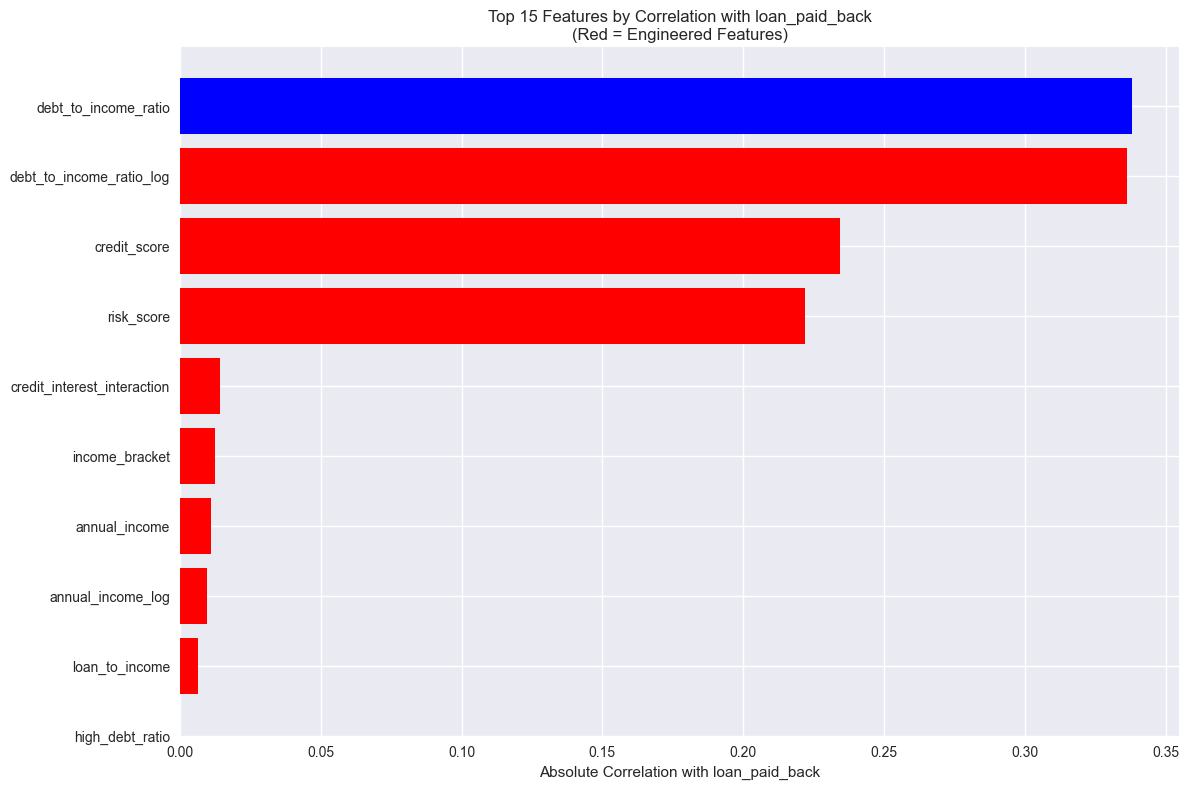


✓ Feature importance analysis completed
✓ 8 engineered features found in top 10


In [327]:
#correlations = analyze_feature_importance(X_train_scaled, y_train)
feature_correlations, engineered_features = analyze_feature_importance(X_train_scaled, y_train)

In [328]:
import pandas as pd
import joblib
import json

def save_preprocessing_outputs(
    df_original,
    df_preprocessed,
    X_train_scaled,
    X_val_scaled,
    X_test_scaled,
    y_train,
    y_val,
    y_test,
    scaler,
    selected_features,
    engineered_features,
    feature_importance,
    log_transformed=None,
    outlier_treatment='IQR_capping',
    scaling_method='StandardScaler'
):
    """
    SAVE PREPROCESSED DATASETS AND METADATA
    =======================================

    Purpose:
        - Save all preprocessed data, target variables, scaling model, 
          selected features, engineered features, and feature importance summary.
        - Provides reproducibility and transparency for downstream modeling.

    Parameters:
        df_original (pd.DataFrame): Original dataset before preprocessing.
        df_preprocessed (pd.DataFrame): Final processed dataset after preprocessing.
        X_train_scaled, X_val_scaled, X_test_scaled (pd.DataFrame): Scaled feature sets.
        y_train, y_val, y_test (pd.Series): Target variables.
        scaler: Fitted StandardScaler (or other scaling object).
        selected_features (list): List of features retained after selection.
        engineered_features (list): List of engineered feature names.
        feature_importance (pd.DataFrame): DataFrame containing feature importance info with columns ['feature', 'correlation'].
        log_transformed (list, optional): List of features log-transformed.
        outlier_treatment (str, optional): Outlier handling method used.
        scaling_method (str, optional): Scaling technique applied.
    """

    print("=== SAVING PREPROCESSING OUTPUTS ===")

    # 1. Save scaled datasets
    X_train_scaled.to_csv('X_train_scaled.csv', index=False)
    X_val_scaled.to_csv('X_val_scaled.csv', index=False)
    X_test_scaled.to_csv('X_test_scaled.csv', index=False)

    # 2. Save target variables
    y_train.to_csv('y_train.csv', index=False)
    y_val.to_csv('y_val.csv', index=False)
    y_test.to_csv('y_test.csv', index=False)

    # 3. Save preprocessing objects
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(selected_features, 'selected_features.pkl')
    #joblib.dump(engineered_features, 'engineered_features.pkl')

    # 4. Save feature importance
    if isinstance(feature_importance, pd.DataFrame):
        feature_importance.to_csv('feature_importance.csv', index=False)
    else:
        print("Warning: feature_importance is not a DataFrame, skipping CSV save.")

    # 5. Save preprocessing summary
    preprocessing_summary = {
        'original_shape': df_original.shape,
        'final_shape': df_preprocessed.shape,
        'selected_features': selected_features,
        'engineered_features': engineered_features,
        'train_samples': X_train_scaled.shape[0],
        'val_samples': X_val_scaled.shape[0],
        'test_samples': X_test_scaled.shape[0],
        'scaling_method': scaling_method,
        'outlier_treatment': outlier_treatment,
        'log_transformed': log_transformed if log_transformed else []
    }

    with open('preprocessing_summary.json', 'w') as f:
        json.dump(preprocessing_summary, f, indent=2)

    print("✓ Preprocessed data saved successfully!\n")
    print("Created files:")
    print("- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv")
    print("- y_train.csv, y_val.csv, y_test.csv")
    print("- scaler.pkl, selected_features.pkl, engineered_features.pkl")
    print("- feature_importance.csv, preprocessing_summary.json")
    print("\nAll preprocessing artifacts saved and ready for modeling.\n")


In [ ]:
save_preprocessing_outputs(
    df_original=df,                      # before preprocessing
    df_preprocessed=df_preprocessed,     # after preprocessing
    X_train_scaled=X_train_scaled,
    X_val_scaled=X_val_scaled,
    X_test_scaled=X_test_scaled,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    scaler=scaler,
    selected_features=list(df_selected.columns),  # convert Index to list
    engineered_features=engineered_features,
    feature_importance = feature_correlations,     # match parameter name
    log_transformed=['annual_income_log', 'debt_to_income_ratio_log'],                       
    outlier_treatment='IQR_capping',
    scaling_method='StandardScaler'
)


=== SAVING PREPROCESSING OUTPUTS ===
✓ Preprocessed data saved successfully!

Created files:
- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv
- y_train.csv, y_val.csv, y_test.csv
- scaler.pkl, selected_features.pkl, engineered_features.pkl
- feature_importance.csv, preprocessing_summary.json

All preprocessing artifacts saved and ready for modeling.

